In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Get data ready for model training

In [13]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
IMAGE_DIR_PATH = "/Users/aaryanpotdar/Desktop/Personal_Projects/TomatoDiseaseClassification/data"
CHANNELS = 3
EPOCHS = 30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIR_PATH,
    shuffle=True, # randomly shuffle images
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Healthy',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Mosaic_virus',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites',
 'Tomato_Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus']

In [6]:
len(dataset)

501

In [8]:
501 * 32 # Batch split

16032

In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy()) # every element is a tensor so we convert to numpy

(32, 256, 256, 3)
[9 0 9 8 9 5 3 4 1 6 6 9 8 1 1 6 3 1 9 2 8 6 9 0 1 5 9 5 9 8 6 5]


In [12]:
# Output:
# (32, 256, 256, 3) -> 3 channels for RGB
# [9 0 9 8 9 5 3 4 1 6 6 9 8 1 1 6 3 1 9 2 8 6 9 0 1 5 9 5 9 8 6 5] - integers indicate class

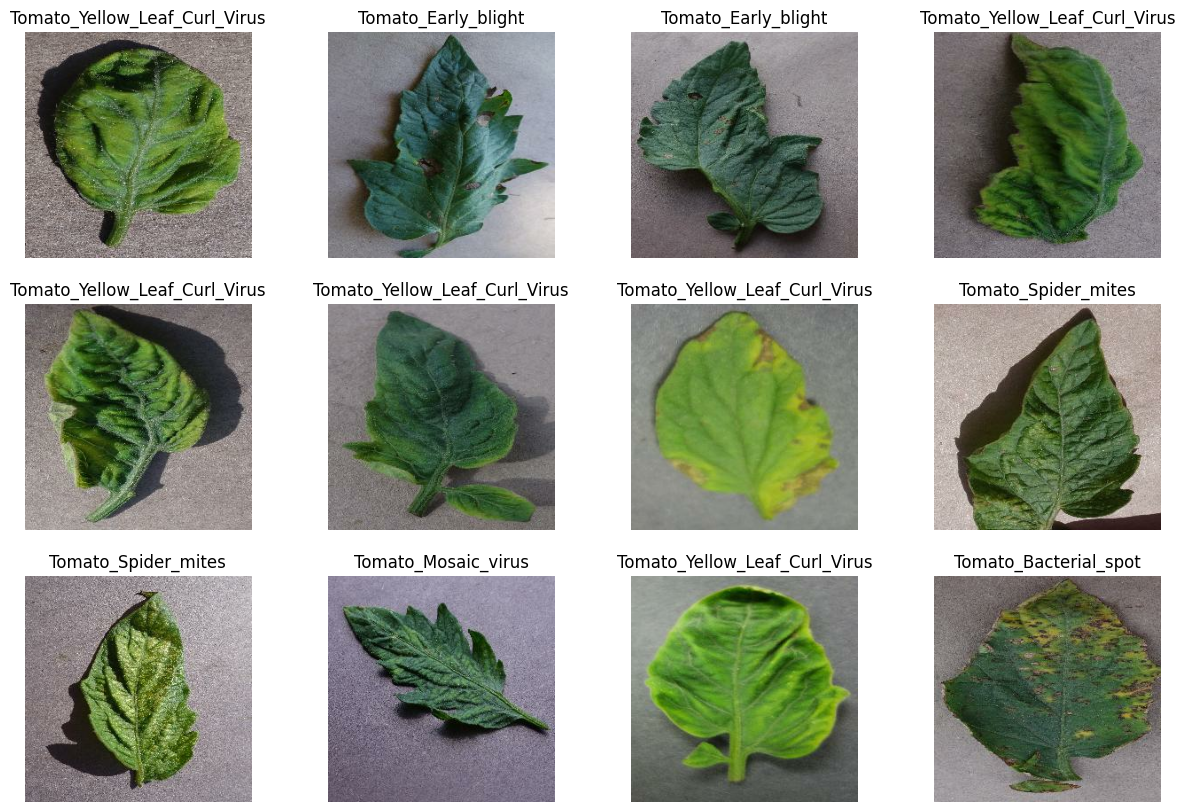

In [27]:
plt.figure(figsize=(15,10)) # set area of images to 10 x 10

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        # print(image_batch[0].numpy())
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [29]:
len(dataset)

# 80% ==> training data
# 20% ==> 10% -> validation, 10% -> test data
# vallidation will be used in each epoch

501

In [31]:
train_size = 0.8
len(dataset) * train_size

400.8

In [32]:
train_ds = dataset.take(400)
len(train_ds)

400

In [34]:
test_ds = dataset.skip(400)
len(test_ds)

101

In [35]:
val_size = 0.1
len(dataset) * val_size

50.1

In [36]:
val_ds = test_ds.take(50)
len(val_ds)

50

In [37]:
test_ds = test_ds.skip(50)
len(test_ds)

51

In [42]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [44]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [45]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

400
51
50


In [46]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# optimization 

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [49]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [51]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [53]:
len(class_names)

10

In [56]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)), # preserve features and reduce the size of image

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])

model.build(input_shape=input_shape)

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_7 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [95]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
NUM_CLASSES = 10

# Data Preprocessing and Augmentation for training
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

# Data Preprocessing for validation and testing (No data augmentation)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load Dataset - Replace with your dataset paths
train_generator = train_datagen.flow_from_directory(
    '/Users/aaryanpotdar/Desktop/Personal_Projects/TomatoDiseaseClassification/dataset/train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    '/Users/aaryanpotdar/Desktop/Personal_Projects/TomatoDiseaseClassification/dataset/validation',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    '/Users/aaryanpotdar/Desktop/Personal_Projects/TomatoDiseaseClassification/dataset/test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Load Pre-Trained ResNet Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Modify Network
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 12804 images belonging to 10 classes.
Found 1601 images belonging to 10 classes.
Found 1606 images belonging to 10 classes.


In [96]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

print("Class Indices:", class_indices)
print("Class Names:", class_names)

Class Indices: {'Tomato_Bacterial_spot': 0, 'Tomato_Early_blight': 1, 'Tomato_Healthy': 2, 'Tomato_Late_blight': 3, 'Tomato_Leaf_Mold': 4, 'Tomato_Mosaic_virus': 5, 'Tomato_Septoria_leaf_spot': 6, 'Tomato_Spider_mites': 7, 'Tomato_Target_Spot': 8, 'Tomato_Yellow_Leaf_Curl_Virus': 9}
Class Names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Mosaic_virus', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites', 'Tomato_Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus']


In [97]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Training Parameters
EPOCHS = 30
STEPS_PER_EPOCH = train_generator.samples // BATCH_SIZE
VALIDATION_STEPS = validation_generator.samples // BATCH_SIZE

In [98]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

callbacks_list = [checkpoint, early_stopping]

# ModelCheckpoint callback saves the best model based on validation loss, and 
# EarlyStopping stops training if the validation loss does not improve for a specified number of epochs (patience).

In [99]:
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks_list
)

Epoch 1/30
400/400 [==============================] - ETA: 0s - loss: 0.5590 - accuracy: 0.8315
Epoch 1: val_loss improved from inf to 0.30511, saving model to best_model.h5
400/400 [==============================] - 397s 989ms/step - loss: 0.5590 - accuracy: 0.8315 - val_loss: 0.3051 - val_accuracy: 0.9062
Epoch 2/30


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


400/400 [==============================] - ETA: 0s - loss: 0.2358 - accuracy: 0.9344
Epoch 2: val_loss improved from 0.30511 to 0.22747, saving model to best_model.h5
400/400 [==============================] - 360s 900ms/step - loss: 0.2358 - accuracy: 0.9344 - val_loss: 0.2275 - val_accuracy: 0.9287
Epoch 3/30
400/400 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9479
Epoch 3: val_loss improved from 0.22747 to 0.19157, saving model to best_model.h5
400/400 [==============================] - 350s 874ms/step - loss: 0.1773 - accuracy: 0.9479 - val_loss: 0.1916 - val_accuracy: 0.9406
Epoch 4/30
400/400 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9555
Epoch 4: val_loss improved from 0.19157 to 0.18442, saving model to best_model.h5
400/400 [==============================] - 346s 864ms/step - loss: 0.1478 - accuracy: 0.9555 - val_loss: 0.1844 - val_accuracy: 0.9381
Epoch 5/30
400/400 [==============================] - ETA: 0s - loss: 0.

In [102]:
scores = model.evaluate(test_generator)

51/51 [==============================] - 42s 824ms/step - loss: 0.1611 - accuracy: 0.9514


In [104]:
scores
# [loss, accuracy]

[0.16113948822021484, 0.9514321088790894]

In [105]:
history

In [106]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 400}

In [111]:
len(history.history['accuracy']) # num of epochs

30

In [112]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

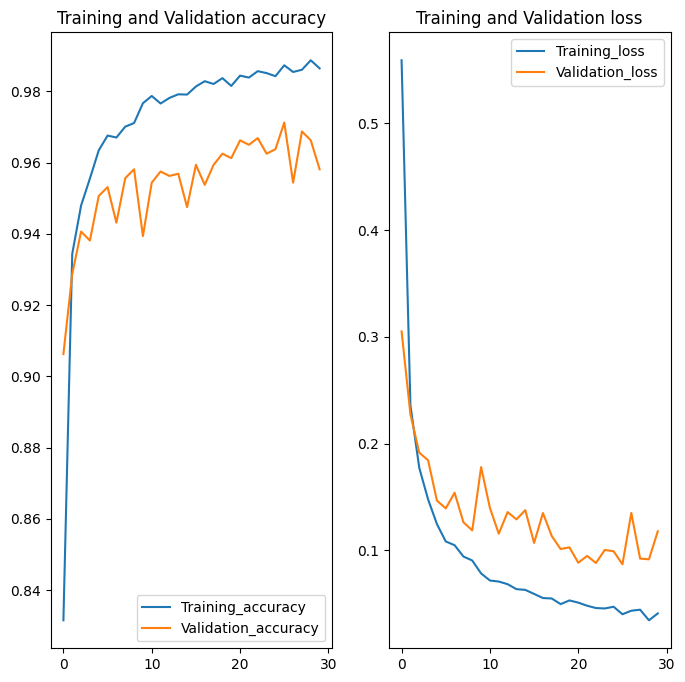

In [115]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training_accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation_accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training_loss')
plt.plot(range(EPOCHS), val_loss, label='Validation_loss')
plt.legend(loc='upper right')
plt.title("Training and Validation loss")
plt.show()

Prediction on first image from test set

1/1 [==============================] - 0s 104ms/step


Predicted Class: Tomato_Spider_mites
Actual Class: Tomato_Spider_mites


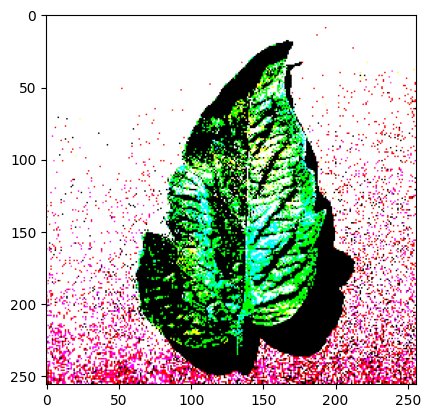

In [127]:
import numpy as np

test_images, test_labels = next(test_generator)

first_image = test_images[0]
first_image_label = test_labels[0]
first_image_expanded = np.expand_dims(first_image, axis=0)

prediction = model.predict(first_image_expanded)
predicted_class = np.argmax(prediction, axis=1)

plt.imshow(first_image)
print(f"Predicted Class: {class_names[predicted_class[0]]}")
print(f"Actual Class: {class_names[np.argmax(first_image_label)]}")

In [125]:
model_version = 1
model.save(filepath=f"/Users/aaryanpotdar/Desktop/Personal_Projects/TomatoDiseaseClassification/models/{model_version}")

INFO:tensorflow:Assets written to: /Users/aaryanpotdar/Desktop/Personal_Projects/TomatoDiseaseClassification/models/1/assets


INFO:tensorflow:Assets written to: /Users/aaryanpotdar/Desktop/Personal_Projects/TomatoDiseaseClassification/models/1/assets


In [126]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Healthy',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Mosaic_virus',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites',
 'Tomato_Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus']